<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [ ]:
# Descargar la carpeta de dataset
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip   
else:
    print("El dataset ya se encuentra descargado")

In [ ]:
# Posibles bandas
os.listdir("./songs_dataset/")

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
cd '/content/drive/MyDrive/Colab_Notebooks/NLP/Clase 4'

/content/drive/MyDrive/Colab_Notebooks/NLP/Clase 4


In [8]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('ESDLA_1cap.txt', sep='\n', header=None)
df.head()

,0
0,Este libro trata principalmente de los Hobbits...
1,sus páginas mucho del carácter y algo de la hi...
2,encontrarse más información en los extractos d...
3,Oeste que ya han sido publicados con el título...
4,origen en los primeros capítulos del Libro Roj...


In [11]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 280


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [10]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
from keras.preprocessing.sequence import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [12]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.loc[0,0]
text

'Este libro trata principalmente de los Hobbits, y el lector descubrirá en'

In [13]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['este',
 'libro',
 'trata',
 'principalmente',
 'de',
 'los',
 'hobbits',
 'y',
 'el',
 'lector',
 'descubrirá',
 'en']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [14]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [15]:
# Demos un vistazo
sentence_tokens[:2]

[['este',
  'libro',
  'trata',
  'principalmente',
  'de',
  'los',
  'hobbits',
  'y',
  'el',
  'lector',
  'descubrirá',
  'en'],
 ['sus',
  'páginas',
  'mucho',
  'del',
  'carácter',
  'y',
  'algo',
  'de',
  'la',
  'historia',
  'de',
  'este',
  'pueblo',
  'podrá']]

In [16]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [17]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences 

[['este', 'libro', 'trata', 'principalmente'],
 ['libro', 'trata', 'principalmente', 'de'],
 ['trata', 'principalmente', 'de', 'los'],
 ['principalmente', 'de', 'los', 'hobbits'],
 ['de', 'los', 'hobbits', 'y'],
 ['los', 'hobbits', 'y', 'el'],
 ['hobbits', 'y', 'el', 'lector'],
 ['y', 'el', 'lector', 'descubrirá']]

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [18]:
tok = Tokenizer() 

# El tokeinzer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [19]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[10, 8, 6, 1],
 [8, 6, 1, 2],
 [6, 1, 2, 3],
 [1, 2, 3, 4],
 [2, 3, 4, 5],
 [3, 4, 5, 7],
 [4, 5, 7, 9],
 [5, 7, 9, 11]]

In [20]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

8


In [21]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

11


In [22]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'principalmente': 1, 'de': 2, 'los': 3, 'hobbits': 4, 'y': 5, 'trata': 6, 'el': 7, 'libro': 8, 'lector': 9, 'este': 10, 'descubrirá': 11}


In [23]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'libro': 2, 'principalmente': 4, 'este': 1, 'trata': 3, 'de': 4, 'los': 4, 'hobbits': 4, 'y': 4, 'el': 3, 'lector': 2, 'descubrirá': 1})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [24]:
# Vistazo a las primeras filas
df.loc[:15,0]

0     Este libro trata principalmente de los Hobbits...
1     sus páginas mucho del carácter y algo de la hi...
2     encontrarse más información en los extractos d...
3     Oeste que ya han sido publicados con el título...
4     origen en los primeros capítulos del Libro Roj...
5     primer Hobbit que fue famoso en el mundo enter...
6     una ida y de una vuelta, pues contaba el viaje...
7     aventura que más tarde enredaría a todos los H...
8                  acontecimientos que aquí se relatan.
9      No obstante, muchos querrán saber desde un pr...
10    pueblo notable y quizás algunos no tengan el l...
11    se han reunido aquí algunas notas sobre los pu...
12    tradición hobbit, y se recuerda brevemente la ...
13    Los Hobbits son un pueblo sencillo y muy antig...
14    tiempos remotos que en la actualidad. Amaban l...
15    cultivo de la buena tierra, y no había para el...
Name: 0, dtype: object

In [25]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'Este libro trata principalmente de los Hobbits, y el lector descubrirá en sus páginas mucho del carácter y algo de la historia de este pueblo. Podrá encontrarse más información en los extractos del Libro Rojo de la Frontera del Oeste que ya han sido publicados con el título de El Hobbit. El relato tuvo su origen en los primeros capítulos del Libro Rojo, compuesto por Bilbo Bolsón -el primer Hobbit que fue famoso en el mundo entero - y que él tituló Historia de una ida y de una vuelta, pues contaba el viaje de Bilbo hacia el Este y la vuelta, aventura que más tarde enredaría a todos los Hobbits en los importantes acontecimientos que aquí se relatan.  No obstante, muchos querrán saber desde un principio algo más de este pueblo notable y quizás algunos no tengan el libro anterior. Para esos lectores se han reunido aquí algunas notas sobre los puntos más importantes de la tradición hobbit, y se recuerda brevemente la primera aventura.  Los Hobbits son un pueblo sencillo y muy antiguo, más

In [26]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['este',
 'libro',
 'trata',
 'principalmente',
 'de',
 'los',
 'hobbits',
 'y',
 'el',
 'lector',
 'descubrirá',
 'en',
 'sus',
 'páginas',
 'mucho',
 'del',
 'carácter',
 'y',
 'algo',
 'de']

In [27]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 3447


In [28]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [29]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['este', 'libro', 'trata', 'principalmente'],
 ['libro', 'trata', 'principalmente', 'de'],
 ['trata', 'principalmente', 'de', 'los'],
 ['principalmente', 'de', 'los', 'hobbits'],
 ['de', 'los', 'hobbits', 'y'],
 ['los', 'hobbits', 'y', 'el'],
 ['hobbits', 'y', 'el', 'lector'],
 ['y', 'el', 'lector', 'descubrirá'],
 ['el', 'lector', 'descubrirá', 'en'],
 ['lector', 'descubrirá', 'en', 'sus'],
 ['descubrirá', 'en', 'sus', 'páginas'],
 ['en', 'sus', 'páginas', 'mucho'],
 ['sus', 'páginas', 'mucho', 'del'],
 ['páginas', 'mucho', 'del', 'carácter'],
 ['mucho', 'del', 'carácter', 'y'],
 ['del', 'carácter', 'y', 'algo'],
 ['carácter', 'y', 'algo', 'de'],
 ['y', 'algo', 'de', 'la'],
 ['algo', 'de', 'la', 'historia'],
 ['de', 'la', 'historia', 'de']]

In [30]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[27, 51, 356, 357],
 [51, 356, 357, 1],
 [356, 357, 1, 2],
 [357, 1, 2, 12],
 [1, 2, 12, 3],
 [2, 12, 3, 6],
 [12, 3, 6, 358],
 [3, 6, 358, 359],
 [6, 358, 359, 4],
 [358, 359, 4, 101],
 [359, 4, 101, 360],
 [4, 101, 360, 66],
 [101, 360, 66, 11],
 [360, 66, 11, 189],
 [66, 11, 189, 3],
 [11, 189, 3, 124],
 [189, 3, 124, 1],
 [3, 124, 1, 5],
 [124, 1, 5, 59],
 [1, 5, 59, 1]]

In [31]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 3443


### 3 - Input y target

In [32]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [33]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [34]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [35]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(3443, 3)
(3443,)


In [36]:
# Palabras del vocabulario
tok.index_word

{1: 'de',
 2: 'los',
 3: 'y',
 4: 'en',
 5: 'la',
 6: 'el',
 7: 'que',
 8: 'las',
 9: 'a',
 10: 'se',
 11: 'del',
 12: 'hobbits',
 13: 'más',
 14: 'no',
 15: 'con',
 16: 'un',
 17: 'eran',
 18: 'o',
 19: 'por',
 20: 'una',
 21: 'pero',
 22: 'comarca',
 23: 'como',
 24: 'lo',
 25: 'desde',
 26: 'al',
 27: 'este',
 28: 'hombres',
 29: 'muy',
 30: 'ellos',
 31: 'bien',
 32: 'elfos',
 33: 'habían',
 34: 'tierra',
 35: 'había',
 36: 'es',
 37: 'hasta',
 38: 'entre',
 39: 'su',
 40: 'bilbo',
 41: 'tiempos',
 42: 'otros',
 43: 'cuando',
 44: 'grandes',
 45: 'era',
 46: 'tiempo',
 47: 'oeste',
 48: 'para',
 49: 'entonces',
 50: 'tierras',
 51: 'libro',
 52: 'fue',
 53: 'muchos',
 54: 'paz',
 55: 'aunque',
 56: 'menos',
 57: 'días',
 58: 'aún',
 59: 'historia',
 60: 'ya',
 61: 'mundo',
 62: 'si',
 63: 'todo',
 64: 'pies',
 65: 'norte',
 66: 'mucho',
 67: 'pueblo',
 68: 'han',
 69: 'pues',
 70: 'ni',
 71: 'gente',
 72: 'grande',
 73: 'les',
 74: 'fuertes',
 75: 'esa',
 76: 'época',
 77: 'mar',
 

In [37]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

1107

In [38]:
# Transformar los datos a oneHotEncoding
y_data = to_categorical(y_data_int, num_classes=vocab_size)

IndexError: ignored

In [39]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [40]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(3443, 1107)

### 4 - Entrenar el modelo

In [41]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [42]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

1107

In [46]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 3, 5)              5540      
                                                                 
 lstm_2 (LSTM)               (None, 3, 64)             17920     
                                                                 
 dropout_1 (Dropout)         (None, 3, 64)             0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1107)              36531     
                                                                 
Total params: 95,095
Trainable params: 95,095
Non-trai

In [47]:
hist = model.fit(x_data, y_data, epochs=100, validation_split=0.2)

Epoch 1/100
87/87 [==============================] - 5s 15ms/step - loss: 6.5678 - accuracy: 0.0527 - val_loss: 6.0397 - val_accuracy: 0.0769
Epoch 2/100
87/87 [==============================] - 1s 7ms/step - loss: 5.7618 - accuracy: 0.0545 - val_loss: 6.2022 - val_accuracy: 0.0769
Epoch 3/100
87/87 [==============================] - 1s 7ms/step - loss: 5.6965 - accuracy: 0.0588 - val_loss: 6.3276 - val_accuracy: 0.0769
Epoch 4/100
87/87 [==============================] - 1s 8ms/step - loss: 5.6556 - accuracy: 0.0527 - val_loss: 6.4306 - val_accuracy: 0.0769
Epoch 5/100
87/87 [==============================] - 1s 7ms/step - loss: 5.6186 - accuracy: 0.0559 - val_loss: 6.5415 - val_accuracy: 0.0566
Epoch 6/100
87/87 [==============================] - 1s 7ms/step - loss: 5.5819 - accuracy: 0.0548 - val_loss: 6.6944 - val_accuracy: 0.0769
Epoch 7/100
87/87 [==============================] - 1s 8ms/step - loss: 5.5588 - accuracy: 0.0588 - val_loss: 6.8434 - val_accuracy: 0.0769
Epoch 8/100


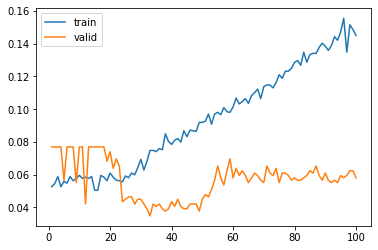

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [ ]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [49]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

     |████████████████████████████████| 1.7 MB 24.1 MB/s 
     |████████████████████████████████| 84 kB 3.1 MB/s 
     |████████████████████████████████| 255 kB 74.5 MB/s 
     |████████████████████████████████| 2.0 MB 57.4 MB/s 
     |████████████████████████████████| 54 kB 3.6 MB/s 
     |████████████████████████████████| 53 kB 2.6 MB/s 
     |████████████████████████████████| 211 kB 77.8 MB/s 
     |████████████████████████████████| 1.1 MB 62.7 MB/s 
     |████████████████████████████████| 271 kB 77.4 MB/s 
     |████████████████████████████████| 94 kB 2.8 MB/s 
     |████████████████████████████████| 144 kB 73.0 MB/s 
     |████████████████████████████████| 58 kB 7.7 MB/s 
     |████████████████████████████████| 10.9 MB 63.1 MB/s 
     |████████████████████████████████| 79 kB 10.5 MB/s 
     |████████████████████████████████| 43 kB 2.6 MB/s 
     |████████████████████████████████| 3.6 MB 60.4 MB/s 
     |████████████████████████████████| 856 kB 64.9 MB/s 
     |████████████████████

In [50]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://38769.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.


(<fastapi.applications.FastAPI at 0x7f6ba88e7350>,
 'http://127.0.0.1:7860/',
 'https://38769.gradio.app')

### 6 - Generación de secuencias nuevas

In [51]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [69]:
input_text='Hace mucho tiempo'

generate_seq(model, tok, input_text, max_length=3, n_words=3)

'Hace mucho tiempo   '

### 7 - Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.